In [19]:
import sys

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import scipy.stats as stats
from scipy.fft import fft, fftfreq
import scipy.signal as sig
from sklearn import linear_model

sys.path.append("../../ndsvae/")
import ndsvae as ndsv

sys.path.append("..")
import plot
import util
import plotutils as pu

%matplotlib inline

## Set matplotlib

In [2]:
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Arial"

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Load data

In [4]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    

def get_results(testcase, config, runs):
    modelname = "AN"
    path = f"../run/main/{testcase}/model{modelname}/{config}"
    ds = ndsv.Dataset.from_file(f"../run/main/{testcase}/dataset.npz")
    run = util.select_run(testcase, modelname, config, [0,1])
    surr   = ndsv.GeneratedData.from_file(f"../run/main/{testcase}/surrogates.npz")
    sims   = ndsv.GeneratedData.from_file(f"{path}/run{run:02d}/simulations.npz")
    params = ndsv.Params.from_file(f"{path}/run{run:02d}/parameters.npz")
        
    return dotdict(ds=ds, sims=sims, params=params, surr=surr)

res = get_results("pmfm_avg", "ns_2_mreg_2_msub_1_nf_32", [0,1])

In [72]:
res.ds.y.shape, res.ds.t[:10]

((8, 68, 1, 1199),
 array([120386.81318681, 121107.69230769, 121828.57142857, 122549.45054945,
        123270.32967033, 123991.20879121, 124712.08791209, 125432.96703297,
        126153.84615385, 126874.72527473]))

In [57]:
def get_mode_limits(y, separating_mass, npoints):
    npoints = 201
    
    lims = np.min(y), np.max(y)
    x = np.linspace(lims[0], lims[1], npoints)    
    pdf, _ = np.histogram(y, bins=x, density=True)
    pdf /= np.sum(pdf)
    cdf = np.cumsum(pdf)

    def mass_interval(cdf, i):
        try:
            return (i, np.where(cdf - cdf[i] >= separating_mass)[0][0])
        except IndexError:
            return None

    mass_intervals = [mass_interval(cdf, i) for i in range(npoints)]
    dists = np.array([(mi[1] - mi[0]) if mi is not None else 0 for mi in mass_intervals])
    
    # To ignore the boundaries
    dists[:-1][cdf < separating_mass] = 0.
    
    ind = np.argmax(dists)
    i1, i2 = mass_intervals[ind]
    
    return x[i1], x[i2]
    
MODE_LIMITS = get_mode_limits(res.ds.y.ravel(), 0.1, 201)

In [58]:
def nswitches(y, axis):
    """Calculates number of switches along the axis"""        
    y = np.moveaxis(y, [axis] + list(np.r_[:axis]), [0] + list(np.r_[1:axis+1]))
    
    state = np.zeros_like(y, dtype=int)
    state[y < MODE_LIMITS[0]] = -1
    state[y > MODE_LIMITS[1]] = 1
    
    nt = y.shape[0]
    
    state[0][state[0] == 0] = 1
    for i in range(1,nt):
        mask = (state[i] == 0)
        state[i][mask] = state[i-1][mask]
      
    return np.log(np.sum((state[1:] - state[:-1]) != 0, axis=0) + 1)


def wdist(x, y):
    assert x.shape[0] == 1
    nsamples, npoints, nt = y.shape
    
    bins = np.linspace(-2, 2, 20+1)
    centers = (bins[1:] + bins[:-1])/2.
    dist = np.zeros((nsamples, npoints))
    
    for j in range(npoints):
        px = np.histogram(x[0,j], bins, density=True)[0]
        px /= np.sum(px)    
        
        for i in range(nsamples):
            py = np.histogram(y[i,j], bins, density=True)[0]
            py /= np.sum(py)
            dist[i,j] = stats.wasserstein_distance(centers, centers, px, py)
    return dist

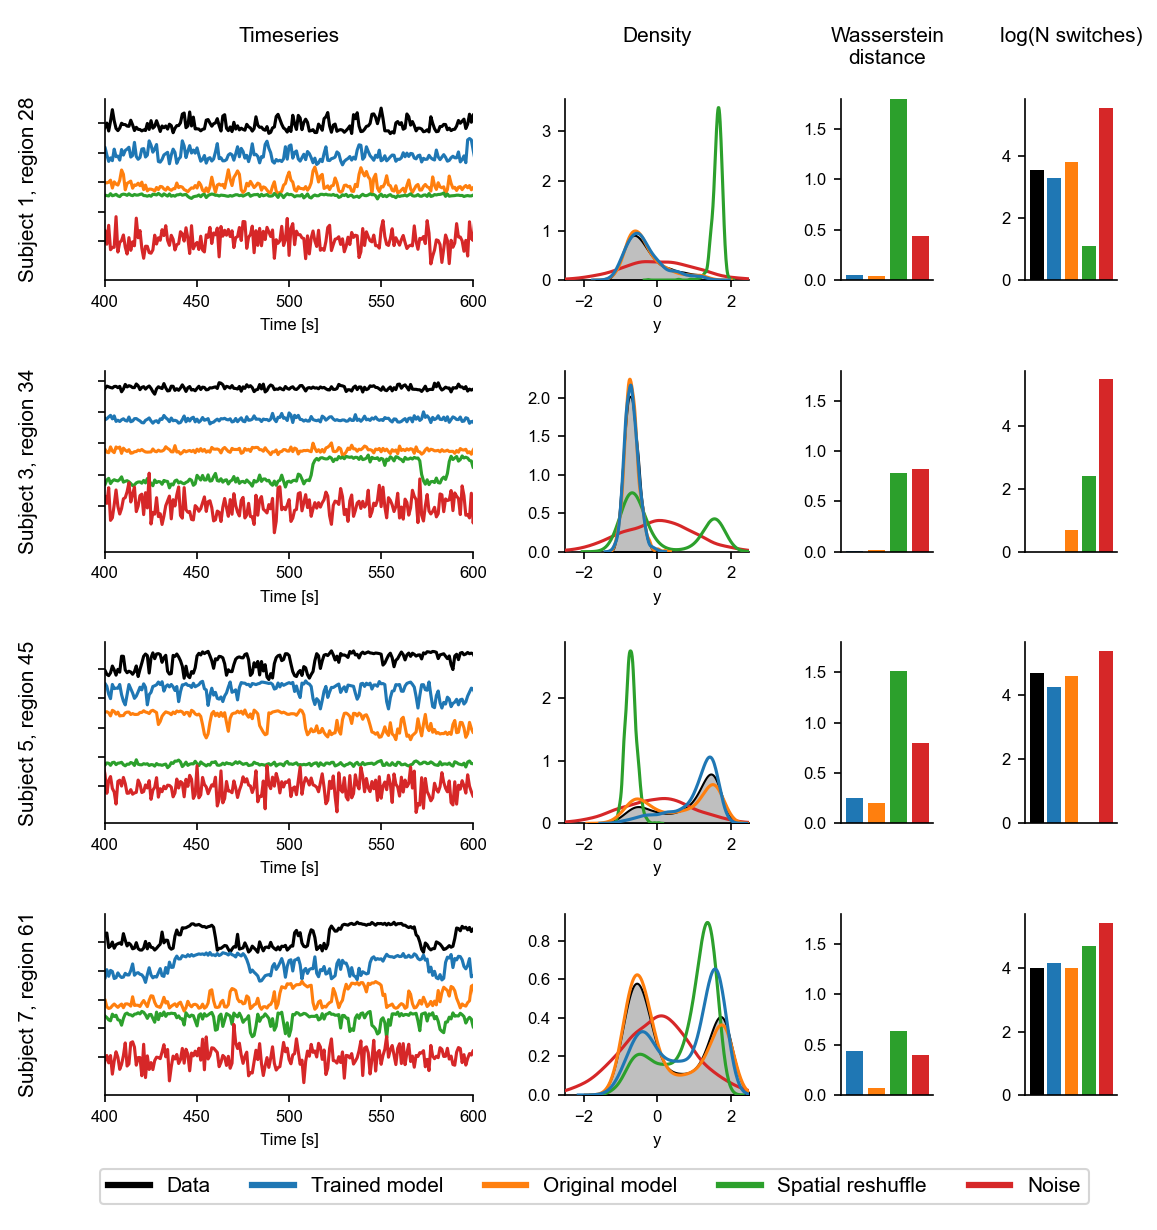

In [78]:
# examples = [(1, 28, 45), (3, 35, 45), (5, 45, 45), (7, 61, 45)]
# examples = [(1, 28, 45), (3, 32, 45), (5, 45, 45), (7, 61, 45)]
examples = [(1, 28, 45), (3, 34, 45), (5, 45, 45), (7, 61, 45)]

n = len(examples)
nt = res.ds.y.shape[-1]
nsub = 8 
nreg = 68

# np.random.seed(46)
# np.random.seed(54)
np.random.seed(46)

colors = ['k', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ["Data", "Trained model", "Original model", "Spatial reshuffle", "Noise"]

fig = plt.figure(figsize=(7.5, n*2), dpi=150)

gs = GridSpec(nrows=n, ncols=4, left=0.08, right=0.98, top=0.93, bottom=0.1,  hspace=0.5, wspace=0.5,
              width_ratios=(2,1,0.5,0.5))


for i, (isub, ireg, irand) in enumerate(examples):
    
    # Get data
    y0 = res.ds.y[isub,ireg,0,:] 
    y1 = res.sims.y[irand,isub,ireg,0,-nt:]
    y2 = res.surr.y[3,isub,ireg,0,:]
    y3 = res.ds.y[np.random.choice(nsub),np.random.choice(nreg),0,:]
    y4 = np.random.normal(0, 1, nt)    
    ys = [y0,y1,y2,y3,y4]
    
    
    # Time series
    ax = plt.subplot(gs[i,0])
    
    for j, y in enumerate(ys):
        plt.plot(y - 3*j, color=colors[j], label=labels[j])
    plt.yticks(-3*np.r_[:5], [""]*5)  
    plt.xlim(400, 600)
    plt.xlabel("Time [s]")
    pu.bottomleft_spines(ax)    
    plt.ylabel(f"Subject {isub}, region {ireg}\n\n", fontsize=10)
    if i == 0:
        plt.title("Timeseries\n\n", fontsize=10)        
    
    if i == n-1:
        leg = plt.legend(bbox_to_anchor=(2.7, -0.35), ncol=5, fontsize=10)
        for line in leg.get_lines():
            line.set_linewidth(3)
    
    # Distributions
    ax = plt.subplot(gs[i,1])
    for j, y in enumerate(ys):
        sns.kdeplot(x=y, color=colors[j], fill=(j==0), zorder=(0 if j == 0 else 10-j))
    plt.xlim(-2.5, 2.5)
    if i == 0:
        plt.title("Density\n\n", fontsize=10)
    plt.ylabel("")
    plt.xlabel("y")
    pu.bottomleft_spines(ax)    
    
    # Wasserstein distance
    ax = plt.subplot(gs[i,2])
    
    plt.bar(np.r_[:4], [wdist(ys[0][None,None,:], y[None,None,:])[0,0] for y in ys[1:]], color=colors[1:])
#     plt.ylim(0, 1.05)
    if i == 0:
        plt.title("Wasserstein\ndistance\n", fontsize=10)
    pu.bottomleft_spines(ax)
    plt.xticks([])
    plt.ylim(0, 1.8)
    
    # Number of switches
    ax = plt.subplot(gs[i,3])
    plt.bar(np.r_[:5], [nswitches(y[None,:], axis=1)[0] for y in ys], color=colors)    
    if i == 0:
        plt.title("log(N switches)\n\n", fontsize=10)
    pu.bottomleft_spines(ax)
    plt.xticks([])



bg = pu.Background(visible=False)
plt.savefig("img/Fig_pmfm_examples.pdf")